In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import cv2
from skimage import color

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

from transformers import ViTForImageClassification, ViTConfig

import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
data_dir = "drive/MyDrive/ia jeux/final_data"
drive_data_path = "/content/drive/MyDrive/ia jeux/final_data"

local_data_path = "/content/local_data"
if os.path.exists(local_data_path):
    shutil.rmtree(local_data_path)

!cp -r "{drive_data_path}" "{local_data_path}"

In [ ]:
INPUT_DIR = "/content/local_data/"
OUTPUT_DIR = "/content/local_data/interpolation_cubique"

def process_images(input_root, output_root, target_size, interpolation):
    
    """"
    Processes images by resizing them to the target size using the specified interpolation method
    """

    if not os.path.exists(output_root):
        os.makedirs(output_root)
    datasets = ['train', 'validation', 'test']
    for dataset in datasets:
        dataset_path = os.path.join(input_root, dataset)
        for species_folder in os.listdir(dataset_path):
            species_path = os.path.join(dataset_path, species_folder)
            if not os.path.isdir(species_path):
                continue
            output_species_path = os.path.join(output_root, dataset, species_folder)
            if not os.path.exists(output_species_path):
                os.makedirs(output_species_path)
            for file in os.listdir(species_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    input_filepath = os.path.join(species_path, file)
                    output_filepath = os.path.join(output_species_path, file)
                    img = cv2.imread(input_filepath)
                    resized_img = cv2.resize(img, target_size, interpolation=interpolation)
                    cv2.imwrite(output_filepath, resized_img)


process_images(INPUT_DIR, OUTPUT_DIR, (128, 128), cv2.INTER_CUBIC)

### Geometric Normalization

To ensure that all images have the same height and width, we decided to perform a cubic interpolation to preserve the image signal with high precision.

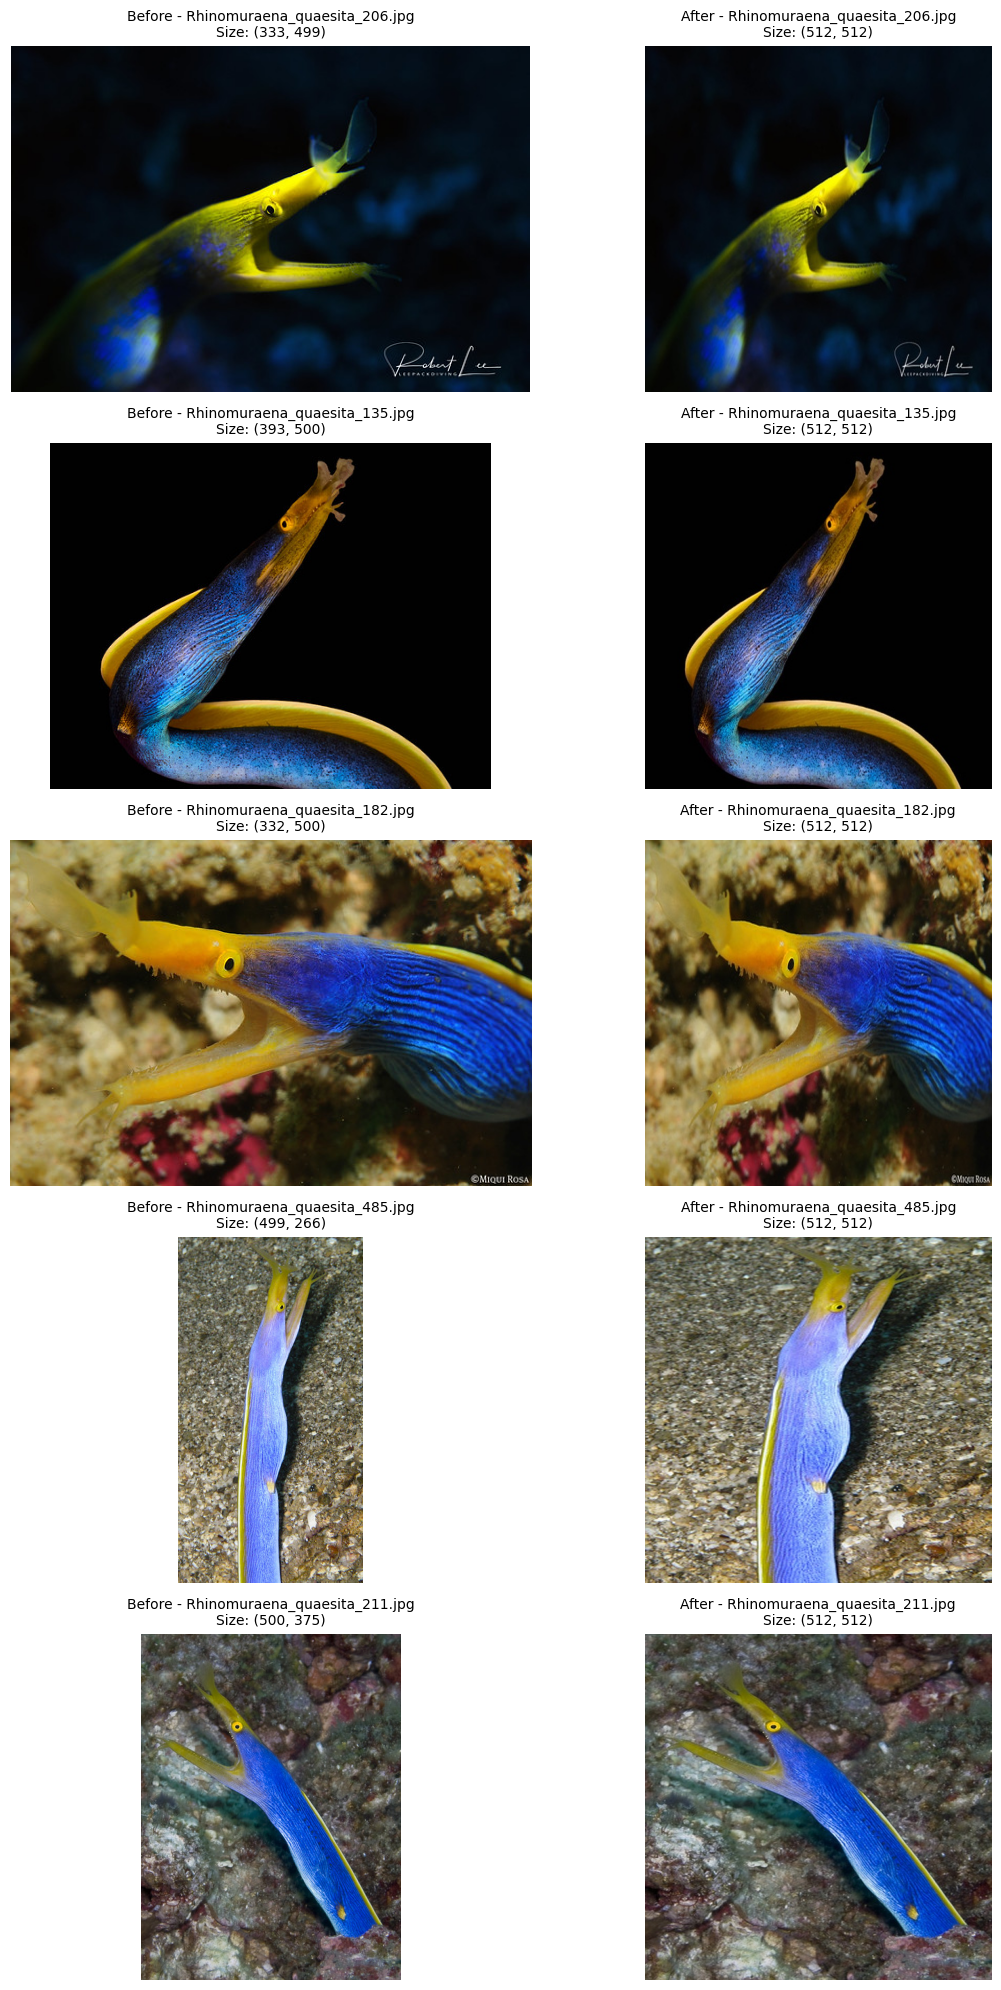

In [ ]:
NORMAL_DIR = "/content/local_data/test/Rhinomuraena_quaesita_ok"
CUBIQUE_DIR = "/content/local_data/interpolation_cubique/test/Rhinomuraena_quaesita_ok"

images_avant = [f for f in os.listdir(NORMAL_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(images_avant, min(5, len(images_avant)))
fig, axes = plt.subplots(5, 2, figsize=(12, 20))

for idx, img_name in enumerate(selected_images):

    img_avant_path = os.path.join(NORMAL_DIR, img_name)
    img_avant_bgr = cv2.imread(img_avant_path)
    img_avant_rgb = cv2.cvtColor(img_avant_bgr, cv2.COLOR_BGR2RGB)
    img_apres_path = os.path.join(CUBIQUE_DIR, img_name)
    img_apres_bgr = cv2.imread(img_apres_path)
    img_apres_rgb = cv2.cvtColor(img_apres_bgr, cv2.COLOR_BGR2RGB)

    axes[idx, 0].imshow(img_avant_rgb)
    axes[idx, 0].set_title(f'Before - {img_name}\nSize: {img_avant_rgb.shape[:2]}', fontsize=10)
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(img_apres_rgb)
    axes[idx, 1].set_title(f'After - {img_name}\nSize: {img_apres_rgb.shape[:2]}', fontsize=10)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

# Teste de Resnet

Found 3155 images belonging to 8 classes.
Found 456 images belonging to 8 classes.
Found 901 images belonging to 8 classes.
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.3663 - loss: 1.8955 - val_accuracy: 0.7917 - val_loss: 0.6627
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6966 - loss: 0.8844 - val_accuracy: 0.8268 - val_loss: 0.5270
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7747 - loss: 0.6720 - val_accuracy: 0.8596 - val_loss: 0.4446
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8223 - loss: 0.5173 - val_accuracy: 0.8618 - val_loss: 0.4186
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8400 - loss: 0.4851 - val_accuracy: 0.8640 - val_loss: 0.4281
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8581 - loss: 0.4215 - val_accuracy: 0.8882 - val_loss: 0.3811
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8700 - loss: 0.3890 - val_accuracy: 0.8728 - val_loss: 0.3918
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8960 - loss: 0.3228 - val_accuracy: 0.8816 - val_loss: 

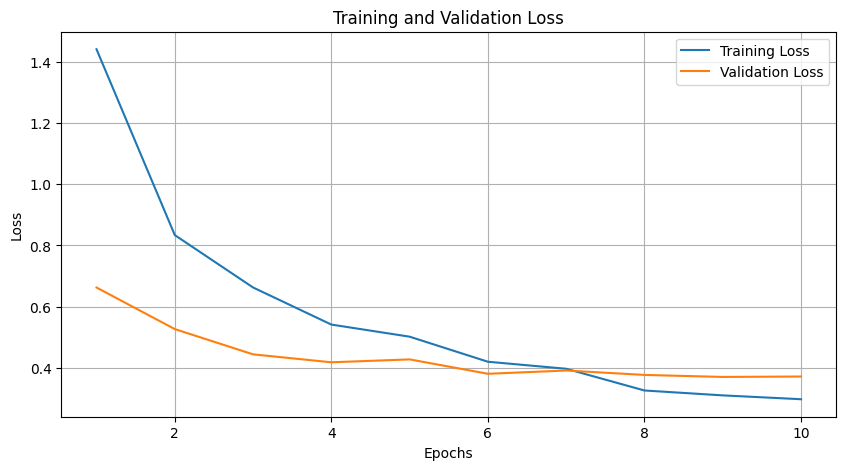

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step
Rapport de Classification :
                            precision    recall  f1-score   support

         Chromis_cyanea_ok       0.91      0.72      0.80       120
        Chromis_viridis_ok       0.76      0.90      0.82        99
Holacanthus_bermudensis_ok       0.91      0.91      0.91       132
           Odonus_niger_ok       0.83      0.82      0.83       129
  Paracanthurus_hepatus_ok       0.83      0.92      0.88       142
  Rhinomuraena_quaesita_ok       0.88      0.91      0.89        97
       Scarus_coeruleus_ok       0.78      0.76      0.77        91
 Thalassoma_bifasciatum_ok       0.79      0.75      0.77        91

                  accuracy                           0.84       901
                 macro avg       0.84      0.84      0.83       901
              weighted avg       0.84      0.84      0.84       901


Matrice de Confusion :


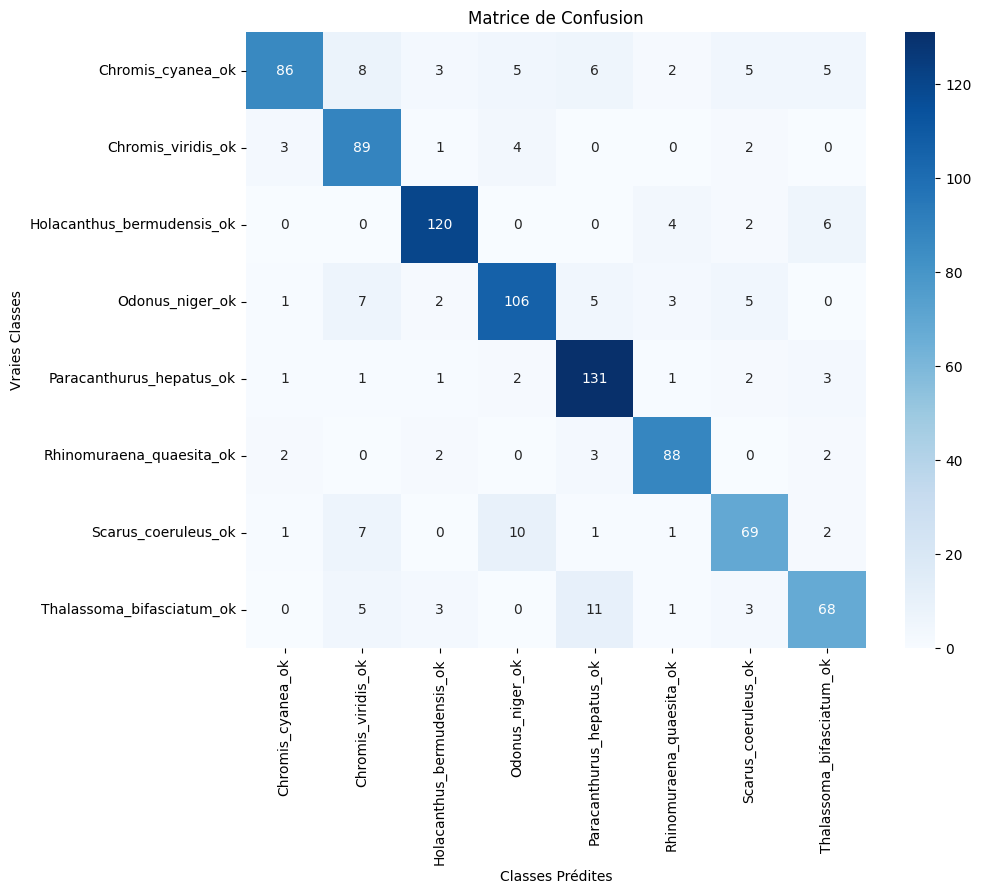

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_dataresnet = datagen_resnet.flow_from_directory(directory=f"{OUTPUT_DIR}/train",target_size=(128, 128),batch_size=32,class_mode='categorical')
val_dataresnet = datagen_resnet.flow_from_directory(directory=f"{OUTPUT_DIR}/validation",target_size=(128, 128),batch_size=32,class_mode='categorical')
test_dataresnet = datagen_resnet.flow_from_directory(directory=f"{OUTPUT_DIR}/test",target_size=(128, 128),batch_size=32,class_mode='categorical',shuffle=False)

# ResNet50 initialization
# Freeze the base model weights so they aren't updated during the first training phase for the transfert learning

base_model = tf.keras.applications.ResNet50(input_shape=(128, 128, 3),include_top=False,weights='imagenet')
base_model.trainable = False
# Build the final model
model = models.Sequential([base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_dataresnet,validation_data=val_dataresnet,epochs=10)
# Visualise training history
plot_metrics(history)


# Reporting pipeline 
predictions = model.predict(test_dataresnet)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_dataresnet.classes
class_labels = list(test_dataresnet.class_indices.keys())

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=0)
print(report)

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.show()

# Teste de MobileNet

Found 3155 images belonging to 8 classes.
Found 456 images belonging to 8 classes.
Found 901 images belonging to 8 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - accuracy: 0.3690 - loss: 1.7549 - val_accuracy: 0.8070 - val_loss: 0.6759
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7370 - loss: 0.7931 - val_accuracy: 0.8180 - val_loss: 0.5281
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7855 - loss: 0.6294 - val_accuracy: 0.8377 - val_loss: 0.4899
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8420 - loss: 0.4560 - val_accuracy: 0.8465 - val_loss: 0.4769
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8541 - loss: 0.4236 - val_accuracy: 0.8706 - val_loss: 0.4715
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8749 - loss: 0.3708 - val_accuracy: 0.8640 - val_loss: 0.4560
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8900 - loss: 0.2988 - val_accuracy: 0.8684 - val_loss: 0.4368
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9187 - loss: 0.2402 - val_accuracy: 0.8728 - val_loss: 

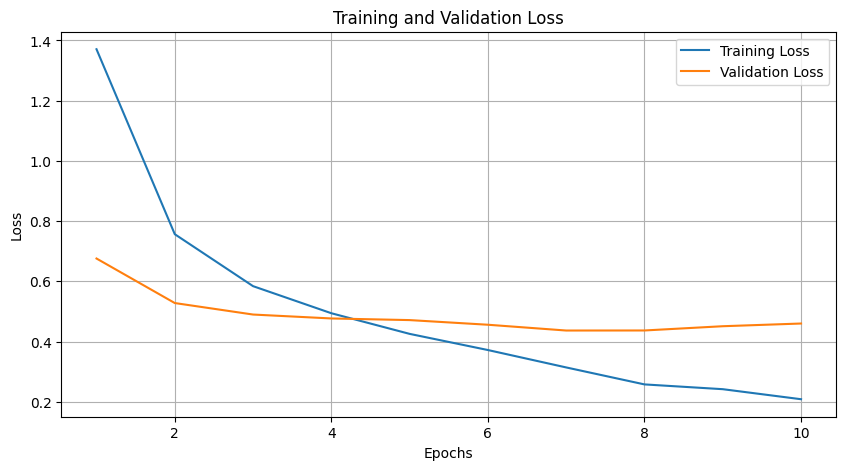

29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step
Rapport de Classification :
                            precision    recall  f1-score   support

         Chromis_cyanea_ok       0.69      0.80      0.74       120
        Chromis_viridis_ok       0.81      0.80      0.81        99
Holacanthus_bermudensis_ok       0.89      0.92      0.90       132
           Odonus_niger_ok       0.92      0.79      0.85       129
  Paracanthurus_hepatus_ok       0.85      0.88      0.87       142
  Rhinomuraena_quaesita_ok       0.90      0.94      0.92        97
       Scarus_coeruleus_ok       0.80      0.80      0.80        91
 Thalassoma_bifasciatum_ok       0.84      0.73      0.78        91

                  accuracy                           0.84       901
                 macro avg       0.84      0.83      0.83       901
              weighted avg       0.84      0.84      0.84       901


Matrice de Confusion :


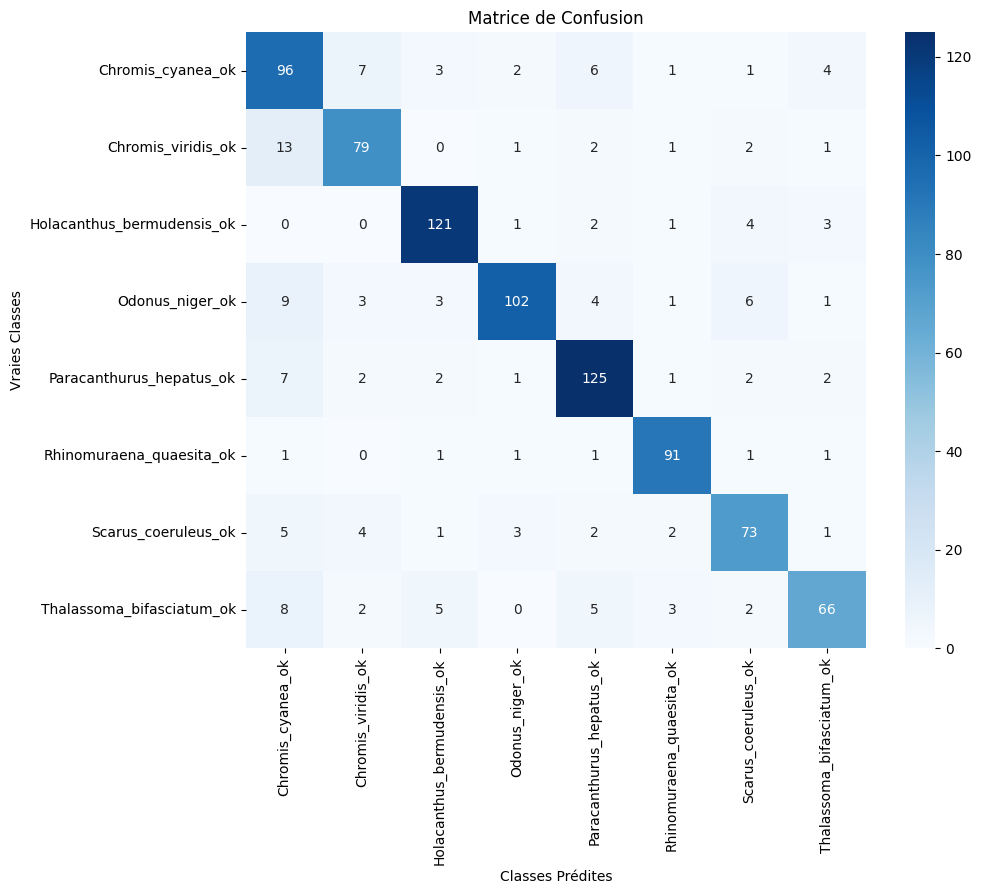

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input)
# Create data generators
train_generator = datagen_mobilenet.flow_from_directory(directory=f"{OUTPUT_DIR}/train",target_size=(128, 128),batch_size=32,class_mode='categorical')
val_generator = datagen_mobilenet.flow_from_directory(directory=f"{OUTPUT_DIR}/validation",target_size=(128, 128),batch_size=32,class_mode='categorical')
test_generator = datagen_mobilenet.flow_from_directory(directory=f"{OUTPUT_DIR}/test",target_size=(128, 128),batch_size=32,class_mode='categorical',shuffle=False)

# MobileNetV2 initialization
# Freeze the base model weights so they aren't updated during the first training phase for the transfert learning

base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),include_top=False,weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator,validation_data=val_generator,epochs=10)

# Build the final model
plot_metrics(history)

# Reporting pipeline 
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=0)
print(report)

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.show()


Canny Edge

I decided to use a Canny filter to outline the fish shape. Since all images are predominantly blue, this approach can help the model focus more on the shape and less on minor color variations. However, since the dataset comprises more than 2,000 photos, finding optimal parameters for the Canny filter was challenging. To solve this issue, I used a Laplacian filter to estimate the noise and apply parameter sets that vary based on the image's noise level.

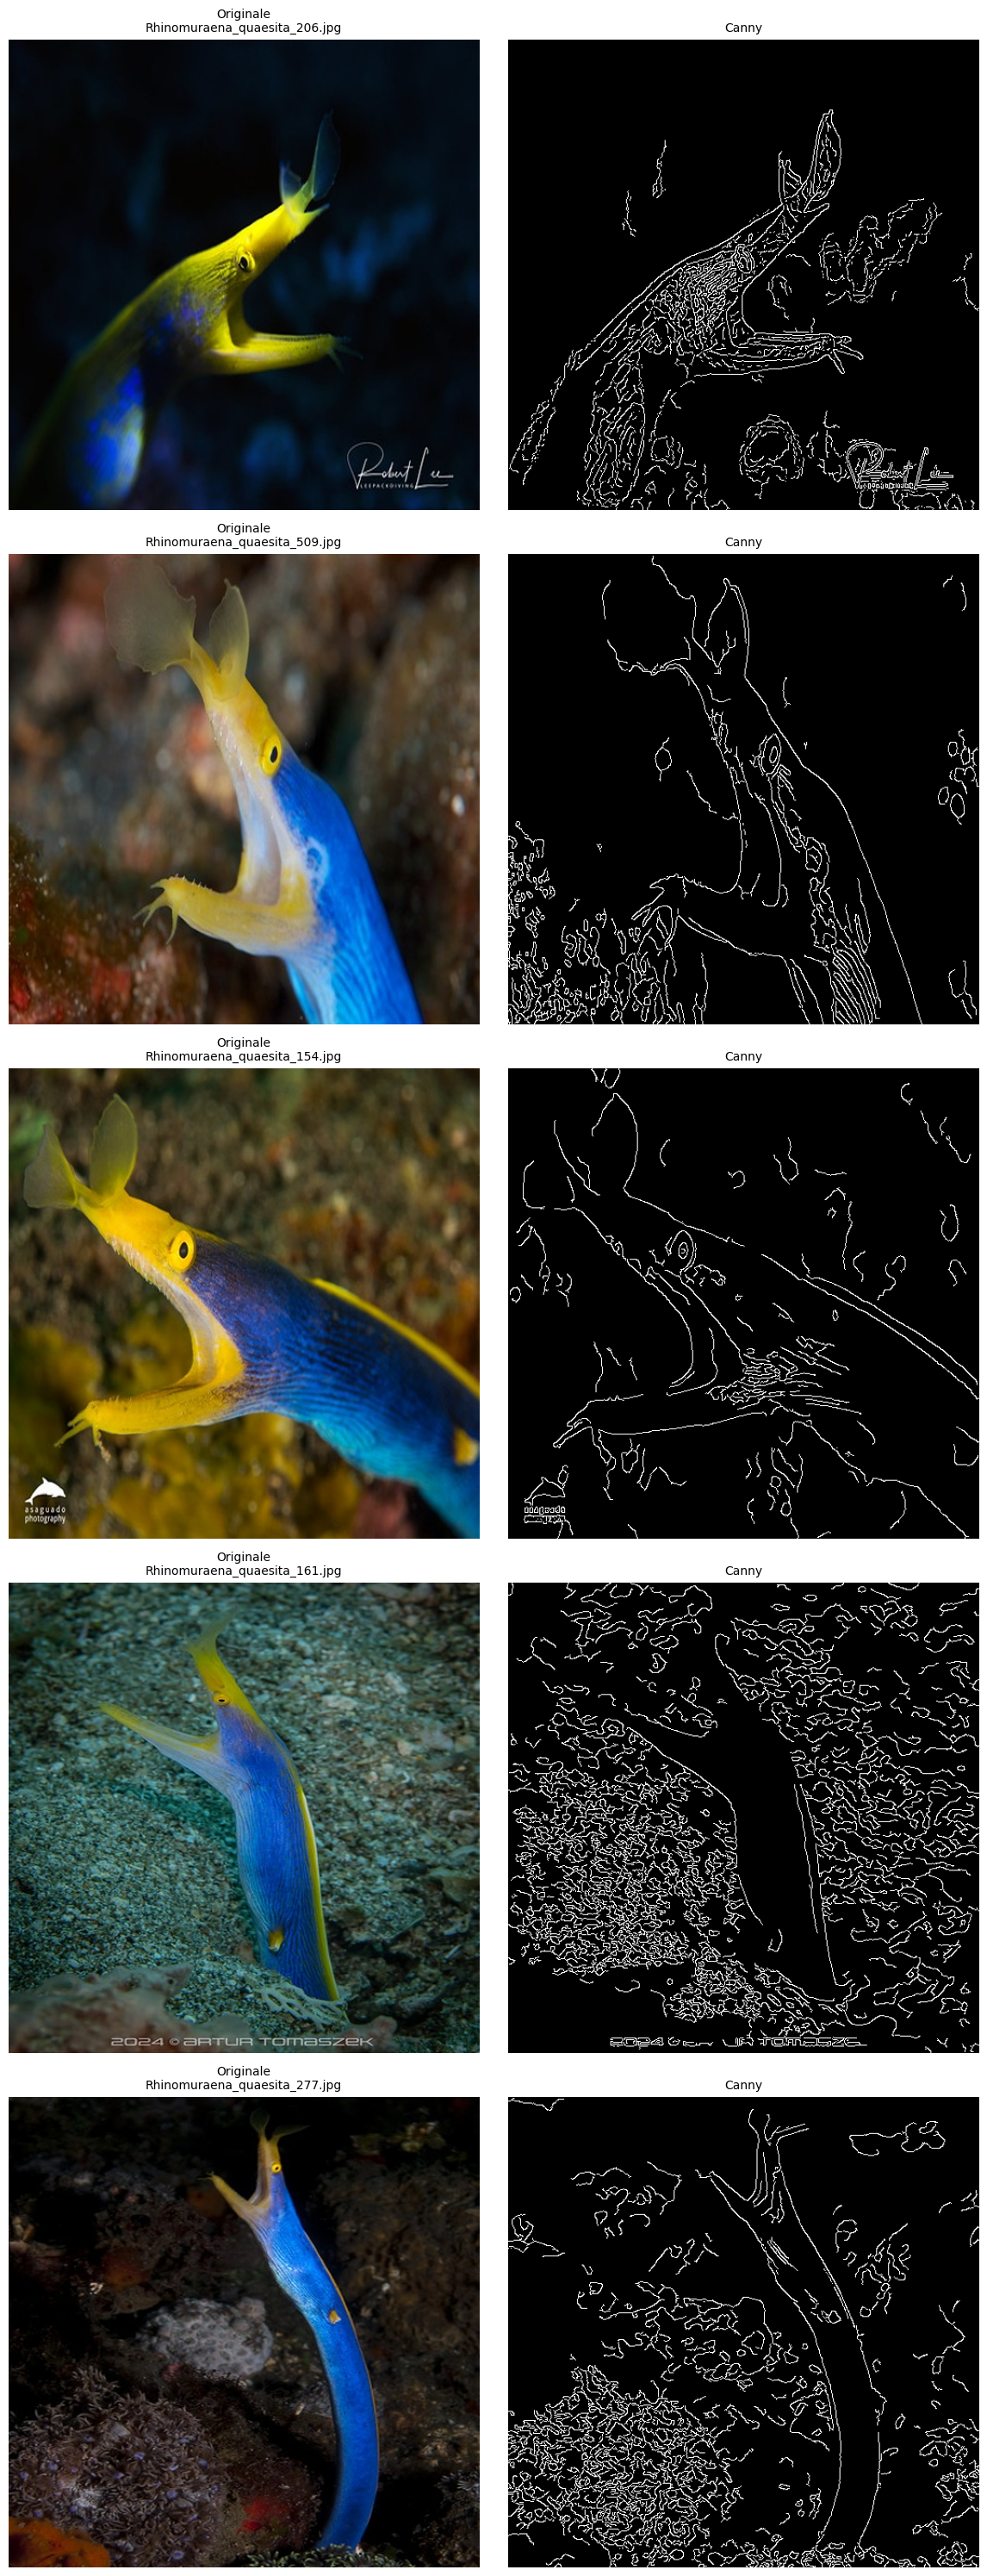

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

SOURCE_DIR = "/content/local_data/interpolation_cubique/test/Rhinomuraena_quaesita_ok"

# Light settings for clean images
BILATERAL_LIGHT_D = 4
BILATERAL_LIGHT_SIGMA_COLOR = 30
BILATERAL_LIGHT_SIGMA_SPACE = 30


# Strong settings for noisy images
BILATERAL_STRONG_D = 9
BILATERAL_STRONG_SIGMA_COLOR = 100
BILATERAL_STRONG_SIGMA_SPACE = 100

# Used to enhance local contrast before edge detection
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def estimate_noise_level(image):
    """
    Estimates image noise using the Variance of the Laplacian
    """
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian_var

def get_bilateral_params(noise_level):
    """
    Selects filtering strength based on the estimated noise level
    """
    LOW_NOISE_THRESHOLD = 300
    HIGH_NOISE_THRESHOLD = 900

    # Low noise
    if noise_level < LOW_NOISE_THRESHOLD:
        return BILATERAL_LIGHT_D, BILATERAL_LIGHT_SIGMA_COLOR, BILATERAL_LIGHT_SIGMA_SPACE, "LÉGER"
    # Medium noise
    elif noise_level < HIGH_NOISE_THRESHOLD:
        d = 7
        sigma_c = (BILATERAL_LIGHT_SIGMA_COLOR + BILATERAL_STRONG_SIGMA_COLOR) // 2
        sigma_s = (BILATERAL_LIGHT_SIGMA_SPACE + BILATERAL_STRONG_SIGMA_SPACE) // 2
        return d, sigma_c, sigma_s, "MOYEN"
    else:
    # High noise
        return BILATERAL_STRONG_D, BILATERAL_STRONG_SIGMA_COLOR, BILATERAL_STRONG_SIGMA_SPACE, "FORT"

def get_canny_thresholds(blurred_img, noise_level):
    """
    Dynamically calculates the Hysteresis Thresholds for Canny based on the median intensity of the image and the noise level
    this methods adapt the thresholds according to the noise level to improve edge detection
    """
    median_intensity = np.median(blurred_img)

    LOW_NOISE_THRESHOLD = 300
    HIGH_NOISE_THRESHOLD = 900

    if noise_level < LOW_NOISE_THRESHOLD:
        lower_factor = 0.5
        upper_factor = 1.5
    elif noise_level < HIGH_NOISE_THRESHOLD:
        lower_factor = 0.66
        upper_factor = 1.66
    else:
        lower_factor = 0.8
        upper_factor = 2.0

    lower_threshold = int(max(0, lower_factor * median_intensity))
    upper_threshold = int(min(255, upper_factor * median_intensity))

    return lower_threshold, upper_threshold

def preprocess_image_canny_path(image_path):
    """
    Pipeline: Load -> Grayscale -> CLAHE -> Denoise -> Canny
    """
    
    # 1. Load and convert to Grayscale
    bgr_img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    # 2. Enhance contrast 
    clahe_img = clahe.apply(gray_img)
    # 3. Analyze noise to determine filter strength
    noise_level = estimate_noise_level(clahe_img)
    d, sigma_c, sigma_s, _ = get_bilateral_params(noise_level)
    # 4. Apply Bilateral Filter
    blurred_img = cv2.bilateralFilter(clahe_img, d=d, sigmaColor=sigma_c, sigmaSpace=sigma_s)
    # 5. Calculate dynamic Canny thresholds
    lower_threshold, upper_threshold = get_canny_thresholds(blurred_img, noise_level)
    # 6. Detect Edges
    canny_edges = cv2.Canny(blurred_img, lower_threshold, upper_threshold)

    return canny_edges

images_disponibles = [f for f in os.listdir(SOURCE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(images_disponibles, min(5, len(images_disponibles)))
fig, axes = plt.subplots(len(selected_images), 2, figsize=(12, 6 * len(selected_images)))

for idx, img_name in enumerate(selected_images):
    img_path = os.path.join(SOURCE_DIR, img_name)

    bgr_img = cv2.imread(img_path)
    canny_edges = preprocess_image_canny_path(img_path)
    axes[idx, 0].imshow(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB))
    axes[idx, 0].set_title(f'Originale\n{img_name}', fontsize=10)
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(canny_edges, cmap='gray')
    axes[idx, 1].set_title(f'Canny', fontsize=10)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def create_model():
    """" 
     Creates and compiles a base model  MobileNetV2 based CNN model for image classification
    """
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([base_model,layers.GlobalAveragePooling2D(),layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

Architecture

I tried two different architectures to see which one yielded the best results. It happens that the classic image has better performance than:

- Canny edge + Grayscale
- Canny edge + RGB

I believe that as it is a large dataset, perhaps the Canny edge thresholds can be improved to achieve better performance.

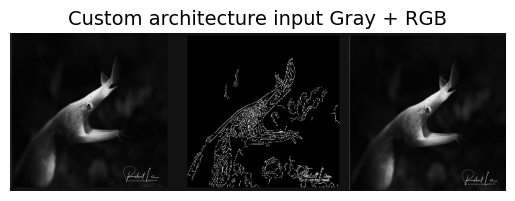

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image as PImage

image_path = '/content/drive/MyDrive/gray_canny.png'

img = PImage.open(image_path)
plt.imshow(img)
plt.title('Custom architecture input Gray + RGB', fontsize=14)

plt.axis('off')
plt.show()

Found 3155 images belonging to 8 classes.
Found 456 images belonging to 8 classes.
Found 901 images belonging to 8 classes.
Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.3725 - loss: 1.7450 - val_accuracy: 0.7829 - val_loss: 0.6948
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7170 - loss: 0.8063 - val_accuracy: 0.8421 - val_loss: 0.5155
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8001 - loss: 0.6079 - val_accuracy: 0.8487 - val_loss: 0.4724
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8506 - loss: 0.4490 - val_accuracy: 0.8640 - val_loss: 0.4267
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8634 - loss: 0.3969 - val_accuracy: 0.8706 - val_loss: 0.4152
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8797 - loss: 0.3405 - val_accuracy: 0.8531 - val_loss: 0.4521
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9043 - loss: 0.2809 - val_accuracy: 0.8596 - va

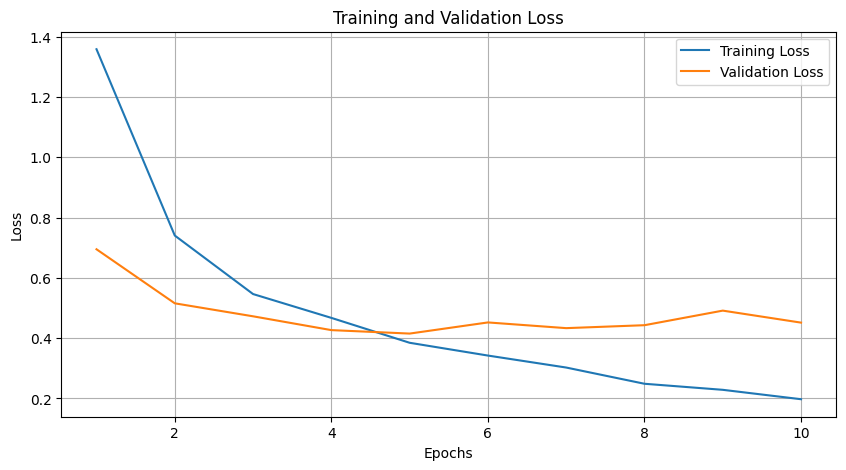

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step
Rapport de Classification :
                            precision    recall  f1-score   support

         Chromis_cyanea_ok       0.70      0.77      0.73       120
        Chromis_viridis_ok       0.87      0.80      0.83        99
Holacanthus_bermudensis_ok       0.94      0.90      0.92       132
           Odonus_niger_ok       0.90      0.85      0.88       129
  Paracanthurus_hepatus_ok       0.85      0.87      0.86       142
  Rhinomuraena_quaesita_ok       0.85      0.96      0.90        97
       Scarus_coeruleus_ok       0.82      0.85      0.83        91
 Thalassoma_bifasciatum_ok       0.81      0.70      0.75        91

                  accuracy                           0.84       901
                 macro avg       0.84      0.84      0.84       901
              weighted avg       0.84      0.84      0.84       901


Matrice de Confusion :


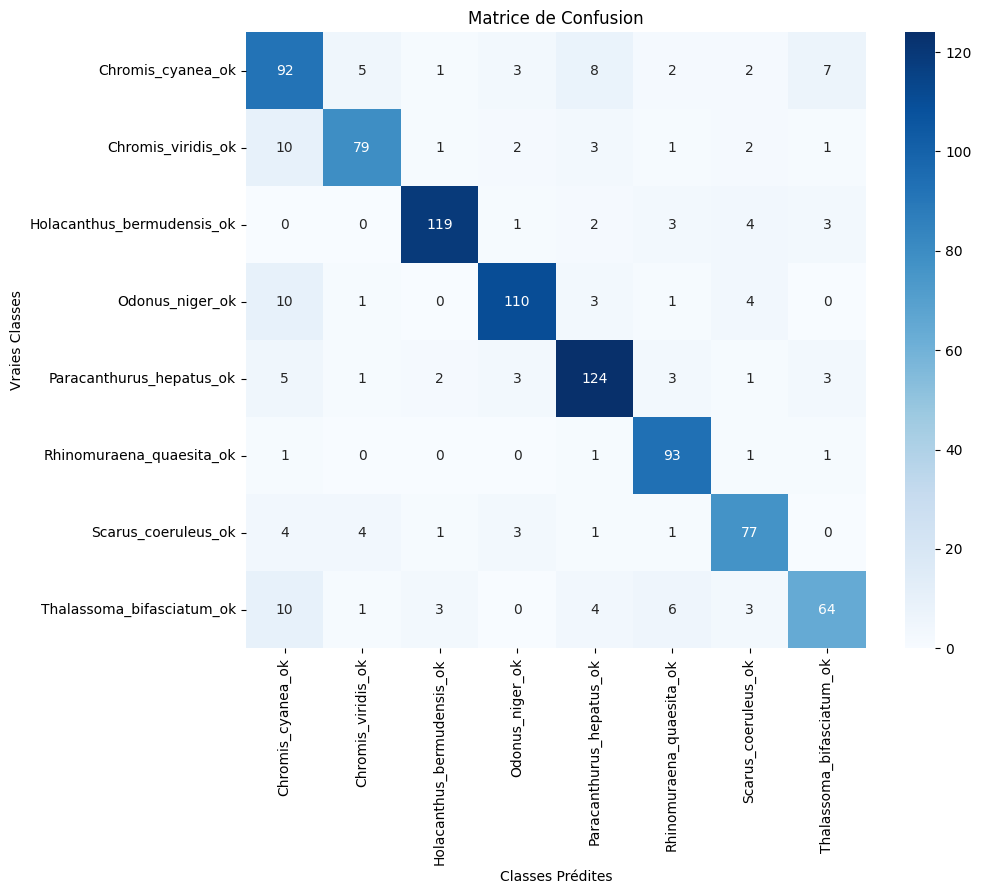

In [ ]:
def preprocess_image_canny(image_array):
    
    if image_array.dtype == np.float32 or image_array.dtype == np.float64:
        image_uint8 = (image_array * 255).astype(np.uint8)
    else:
        image_uint8 = image_array

    if len(image_uint8.shape) == 3:
        gray_img = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = image_uint8

    clahe_img = clahe.apply(gray_img)
    noise_level = estimate_noise_level(clahe_img)
    d, sigma_c, sigma_s, _ = get_bilateral_params(noise_level)
    blurred_img = cv2.bilateralFilter(clahe_img, d=d, sigmaColor=sigma_c, sigmaSpace=sigma_s)
    lower_threshold, upper_threshold = get_canny_thresholds(blurred_img, noise_level)
    canny_edges = cv2.Canny(blurred_img, lower_threshold, upper_threshold)

    return canny_edges

def custom_processing_canny(image):
    """
    Wrapper function for ImageDataGenerator.
    Creates a 3 channel 'Hybrid' image: [Grayscale, Edges, Grayscale].
    """
    if image.dtype == np.float32 or image.dtype == np.float64:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image
    gray_img = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

    # Stack channels to create a fake RGB image
    canny_edges = preprocess_image_canny(image_uint8)
    combined_img = np.stack([gray_img, canny_edges, gray_img], axis=-1)
    combined_img = combined_img.astype(np.float32) / 255.0

    return combined_img

# Apply the custom hybrid processing to every image on the fly
train_datagen = ImageDataGenerator(preprocessing_function=custom_processing_canny)
val_datagen = ImageDataGenerator(preprocessing_function=custom_processing_canny)
test_datagen = ImageDataGenerator(preprocessing_function=custom_processing_canny)

train_canny_rgb = train_datagen.flow_from_directory(directory=f"{local_data_path}/train",target_size=(128, 128),batch_size=32,class_mode='categorical')
val_canny_rgb = val_datagen.flow_from_directory(directory=f"{local_data_path}/validation",target_size=(128, 128),batch_size=32,class_mode='categorical')
test_canny_rgb = test_datagen.flow_from_directory(directory=f"{local_data_path}/test",target_size=(128, 128),batch_size=32,class_mode='categorical',shuffle=False)

# Train the model with the custom processed images and reporting pipeline
model =  create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator,validation_data=val_generator,epochs=10)

plot_metrics(history)

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=0)
print(report)

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.show()

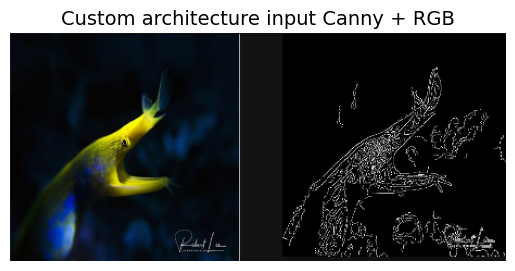

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image as PImage

image_path = '/content/drive/MyDrive/canny_rbg.png'

img = PImage.open(image_path)
plt.imshow(img)
plt.title('Custom architecture input Canny + RGB', fontsize=14)

plt.axis('off')
plt.show()

Found 3155 images belonging to 8 classes.
Found 456 images belonging to 8 classes.
Found 901 images belonging to 8 classes.
Found 3155 images belonging to 8 classes.
Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2940 - loss: 1.9508Found 456 images belonging to 8 classes.
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.2950 - loss: 1.9481 - val_accuracy: 0.6118 - val_loss: 1.1548
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.5684 - loss: 1.2034 - val_accuracy: 0.6930 - val_loss: 0.8998
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.6722 - loss: 0.9356 - val_accuracy: 0.6974 - val_loss: 0.8681
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.7243 - loss: 0.8026 - val_accuracy: 0.7368 - val_loss: 0.7878
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.7593 - loss: 0.6909 - val_accuracy: 0.7193 - val_loss: 0.7756
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.7735 - 

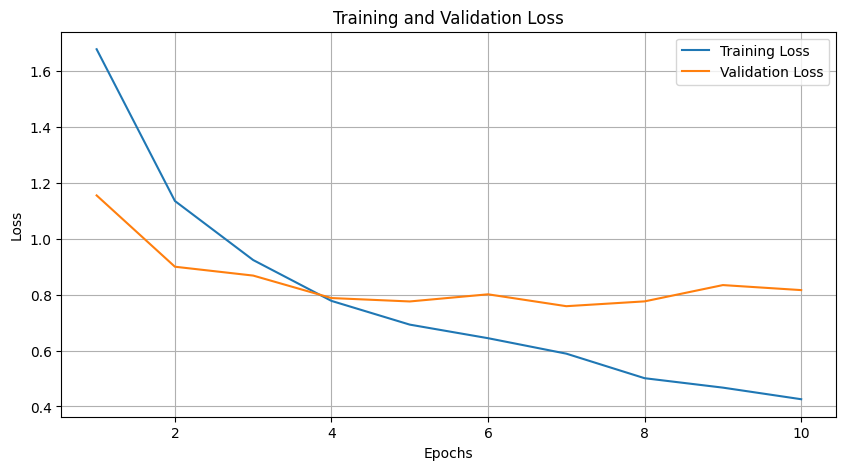

Found 901 images belonging to 8 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 320ms/step
Rapport de Classification :
                            precision    recall  f1-score   support

         Chromis_cyanea_ok       0.59      0.64      0.62       120
        Chromis_viridis_ok       0.74      0.76      0.75        99
Holacanthus_bermudensis_ok       0.83      0.84      0.84       132
           Odonus_niger_ok       0.64      0.77      0.70       129
  Paracanthurus_hepatus_ok       0.85      0.70      0.76       142
  Rhinomuraena_quaesita_ok       0.72      0.93      0.81        97
       Scarus_coeruleus_ok       0.80      0.65      0.72        91
 Thalassoma_bifasciatum_ok       0.86      0.63      0.73        91

                  accuracy                           0.74       901
                 macro avg       0.75      0.74      0.74       901
              weighted avg       0.75      0.74      0.74       901


Matrice de Confusion :


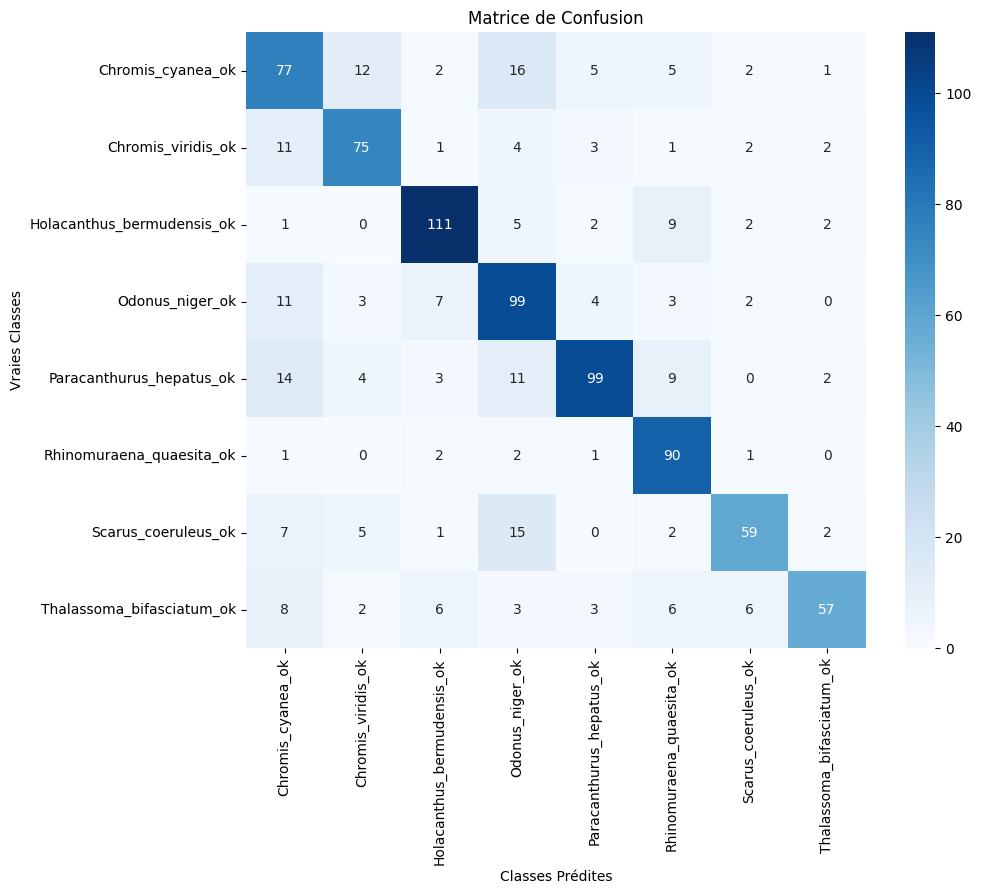

In [ ]:
def custom_processing_canny_rgb(image):
    """
    Creates a 4 channel image by stacking the Canny Edge map onto the RGB image 
    """
    if image.dtype == np.float32 or image.dtype == np.float64:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image
    canny_edges = preprocess_image_canny(image_uint8)
    combined_img = np.concatenate([image_uint8, canny_edges[..., np.newaxis]], axis=-1)
    combined_img = combined_img.astype(np.float32) / 255.0
    return combined_img

def custom_generator(directory, batch_size=32, target_size=(128, 128), class_mode='categorical', shuffle=True):
    """
    A custom Python generator to handle 4 channel input
    Standard Keras ImageDataGenerator cannot easily yield 4 channel
    """
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(directory=directory,target_size=target_size,
        batch_size=batch_size,class_mode=class_mode,shuffle=shuffle)

    while True:
        batch_x, batch_y = next(generator)
        batch_x_processed = np.array([custom_processing_canny_rgb(img) for img in batch_x])
        yield batch_x_processed, batch_y

train_canny_rgb = custom_generator(directory=f"{local_data_path}/train",batch_size=32,
    target_size=(128, 128),class_mode='categorical',shuffle=True)

val_canny_rgb = custom_generator(directory=f"{local_data_path}/validation",batch_size=32,
    target_size=(128, 128),class_mode='categorical',shuffle=False)


# Initialize the 4 channel generators
test_canny_rgb = custom_generator(directory=f"{local_data_path}/test",batch_size=32,target_size=(128, 128),class_mode='categorical',shuffle=False)

train_datagen_temp = ImageDataGenerator()
train_temp = train_datagen_temp.flow_from_directory(directory=f"{local_data_path}/train",target_size=(128, 128),batch_size=32,class_mode='categorical')
val_temp = train_datagen_temp.flow_from_directory(directory=f"{local_data_path}/validation",target_size=(128, 128),batch_size=32,class_mode='categorical')
test_temp = train_datagen_temp.flow_from_directory(directory=f"{local_data_path}/test",target_size=(128, 128),batch_size=32,class_mode='categorical',shuffle=False)

# Custom MobileNetV2 for 4 channel input
# Step A: Load the standard MobileNetV2 3 channel with ImageNet weights
base_model_3ch = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),include_top=False,weights='imagenet')


# Step B: Extract weights from the first convolution layer
first_conv_layer = base_model_3ch.layers[1]
original_weights = first_conv_layer.get_weights()
original_kernel = original_weights[0]

# Step C: Create weights for the new 4th channel
mean_kernel = np.mean(original_kernel, axis=2, keepdims=True)
new_kernel = np.concatenate([original_kernel, mean_kernel], axis=2)

# Step D: Instantiate a NEW MobileNetV2 with 4 channel input
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 4),include_top=False,weights=None)

# Step E: Inject the modified weights into the first layer
if len(original_weights) > 1:
    base_model.layers[1].set_weights([new_kernel, original_weights[1]])
else:
    base_model.layers[1].set_weights([new_kernel])

for i in range(2, len(base_model_3ch.layers)):
    if len(base_model_3ch.layers[i].get_weights()) > 0:
        base_model.layers[i].set_weights(base_model_3ch.layers[i].get_weights())

base_model.trainable = False

# Training & Evaluation
model_4c = models.Sequential([base_model,layers.GlobalAveragePooling2D(),layers.Dense(128, activation='relu'),layers.Dropout(0.5),layers.Dense(64, activation='relu'),layers.Dense(8, activation='softmax')])
model_4c.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model_4c.fit(train_canny_rgb,steps_per_epoch=len(train_temp),validation_data=val_canny_rgb,validation_steps=len(val_temp),epochs=10)

plot_metrics(history)

predictions = model_4c.predict(test_canny_rgb, steps=len(test_temp))
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_temp.classes
class_labels = list(test_temp.class_indices.keys())

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.show()

### Data Augmentation

I also implemented geometrical data augmentation on the images because some of the classes are not equally represented in the dataset. Furthermore, based on the preceding training results, we observed that the model had a particularly hard time detecting the Chromis_cyanea_ok, Chromis_viridis_ok, and Rhinomuraena_quaesita_ok classes because they have fewer images than the other classes. This augmentation will help the model improve its performance on these specific classes.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from collections import Counter

def count_images_per_class(directory):
    """
    Scans a directory structure where subfolders represent classes returns a dictionary mapping class names to the number of valid images found
    """
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
    return class_counts

train_dir = f"{OUTPUT_DIR}/train"
class_counts = count_images_per_class(train_dir)
print("Class distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")
# Determine the size of the largest class (Majority Class).
max_count = max(class_counts.values())
print(f"\nMaximum images: {max_count}")

Class distribution:
  Chromis_viridis_ok: 494 images
  Odonus_niger_ok: 494 images
  Thalassoma_bifasciatum_ok: 494 images
  Paracanthurus_hepatus_ok: 494 images
  Scarus_coeruleus_ok: 494 images
  Chromis_cyanea_ok: 494 images
  Holacanthus_bermudensis_ok: 494 images
  Rhinomuraena_quaesita_ok: 494 images

Maximum images: 494


In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

# Define the geometric transformations used to create synthetic images
augmentation_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
    rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
    zoom_range=[0.8, 1.2],shear_range=0.15,fill_mode='nearest')

def augment_class(class_name, current_count, target_count, class_dir, img_size=(128, 128)):
    """
    Generates new images for a specific class until it reaches the target_count new images are saved physically to the hard drive
    """
    images_needed = target_count - current_count
    if images_needed <= 0:
        return

    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    generated = 0
    while generated < images_needed:
        source_img_name = np.random.choice(image_files)
        source_img_path = os.path.join(class_dir, source_img_name)

        img = load_img(source_img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        aug_iter = augmentation_datagen.flow(img_array,batch_size=1,
            save_to_dir=class_dir,save_prefix='aug',save_format='jpg')

        next(aug_iter)
        generated += 1

for class_name, count in class_counts.items():
    class_dir = os.path.join(train_dir, class_name)
    augment_class(class_name, count, max_count, class_dir)

final_counts = count_images_per_class(train_dir)

datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input)
# Create the flow from the balanced directories

train_generator = datagen_mobilenet.flow_from_directory(directory=train_dir,target_size=(128, 128),
batch_size=32,
    class_mode='categorical',shuffle=True)
val_generator = datagen_mobilenet.flow_from_directory(directory=f"{OUTPUT_DIR}/validation",target_size=(128, 128),batch_size=32,class_mode='categorical')
test_generator = datagen_mobilenet.flow_from_directory(directory=f"{OUTPUT_DIR}/test",target_size=(128, 128),batch_size=32,class_mode='categorical',shuffle=False)

print(f"\n=== Generators Created ===")
print(f"Train: {train_generator.samples} images, {len(train_generator.class_indices)} classes")
print(f"Validation: {val_generator.samples} images")
print(f"Test: {test_generator.samples} images")

Found 3952 images belonging to 8 classes.
Found 456 images belonging to 8 classes.
Found 901 images belonging to 8 classes.

=== Generators Created ===
Train: 3952 images, 8 classes
Validation: 456 images
Test: 901 images


In [ ]:
def create_model(learning_rate, dropout_rate, l2_regularization, dense_units_1, dense_units_2):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units_1, activation='relu', kernel_regularizer=l2(l2_regularization)),
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units_2, activation='relu', kernel_regularizer=l2(l2_regularization)),
        layers.Dense(8, activation='softmax')])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

### Parameter Tuning

For hyperparameter tuning, I decided to use a tool called Optuna. It is an optimization framework that uses Bayesian methods (which is generally more efficient than a grid search) to find the best possible parameters. I have used it several times, and it is a very powerful tool. The parameters we decided to tune include:

- Learning rate
- Dropout
- Layer size
- L2 regularization

In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):

    """
    The main optimization function for Optuna.
    1. Samples hyperparameters.
    2. Trains the model.
    3. Returns a 'score' to minimize Val Loss + Overfitting Penalty.
    """

    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float('dropout_rate', 0.2, 0.7)
    l2_reg = trial.suggest_float('l2_regularization', 1e-5, 1e-2, log=True)
    dense_units_1 = trial.suggest_categorical('dense_units_1', [64, 128, 256, 512])
    dense_units_2 = trial.suggest_categorical('dense_units_2', [32, 64, 128])

    model = create_model(learning_rate=lr,dropout_rate=dropout,l2_regularization=l2_reg,
        dense_units_1=dense_units_1,dense_units_2=dense_units_2)

    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    history = model.fit(train_generator,validation_data=val_generator,epochs=10,verbose=0,callbacks=[pruning_callback])
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    gap = max(0, val_loss - train_loss)

    score = val_loss + gap

    trial.set_user_attr('train_loss', train_loss)
    trial.set_user_attr('val_loss', val_loss)
    trial.set_user_attr('gap', gap)

    return score

# Run the optimization loop

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))
study.optimize(objective, n_trials=30, show_progress_bar=True)

In [ ]:
print(study.best_params)

{'learning_rate': 0.0005153816375541582, 'dropout_rate': 0.5896179371794616, 'l2_regularization': 0.00018589704144455756, 'dense_units_1': 64, 'dense_units_2': 64}


In [ ]:
best_model = create_model(learning_rate=study.best_params['learning_rate'],dropout_rate=study.best_params['dropout_rate'],l2_regularization=study.best_params['l2_regularization'],
    dense_units_1=study.best_params['dense_units_1'],dense_units_2=study.best_params['dense_units_2'])
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)
history = best_model.fit(train_generator,validation_data=val_generator,epochs=30,callbacks=[early_stop],verbose=1)


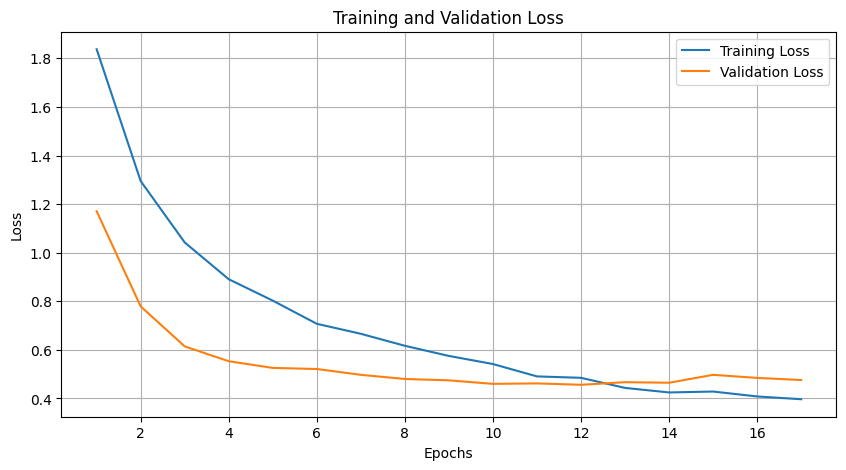

                            precision    recall  f1-score   support

         Chromis_cyanea_ok       0.81      0.76      0.78       120
        Chromis_viridis_ok       0.78      0.80      0.79        99
Holacanthus_bermudensis_ok       0.92      0.91      0.92       132
           Odonus_niger_ok       0.87      0.84      0.85       129
  Paracanthurus_hepatus_ok       0.86      0.87      0.86       142
  Rhinomuraena_quaesita_ok       0.85      0.93      0.89        97
       Scarus_coeruleus_ok       0.76      0.81      0.79        91
 Thalassoma_bifasciatum_ok       0.81      0.77      0.79        91

                  accuracy                           0.84       901
                 macro avg       0.83      0.84      0.83       901
              weighted avg       0.84      0.84      0.84       901



In [ ]:
plot_metrics(history)

test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=0)

predictions = best_model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

### Fine tunning

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 127s 344ms/step - accuracy: 0.6552 - loss: 1.1766 - val_accuracy: 0.8662 - val_loss: 0.4595
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.7172 - loss: 0.9231 - val_accuracy: 0.8728 - val_loss: 0.4646
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7530 - loss: 0.7877 - val_accuracy: 0.8596 - val_loss: 0.4661
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7693 - loss: 0.7339 - val_accuracy: 0.8706 - val_loss: 0.4620
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7948 - loss: 0.6432 - val_accuracy: 0.8706 - val_loss: 0.4550
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8260 - loss: 0.5556 - val_accuracy: 0.8728 - val_loss: 0.4407
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8444 - loss: 0.5202 - val_accuracy: 0.8794 - val_loss: 0.4234
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8554 - loss: 0.4894 - val_a

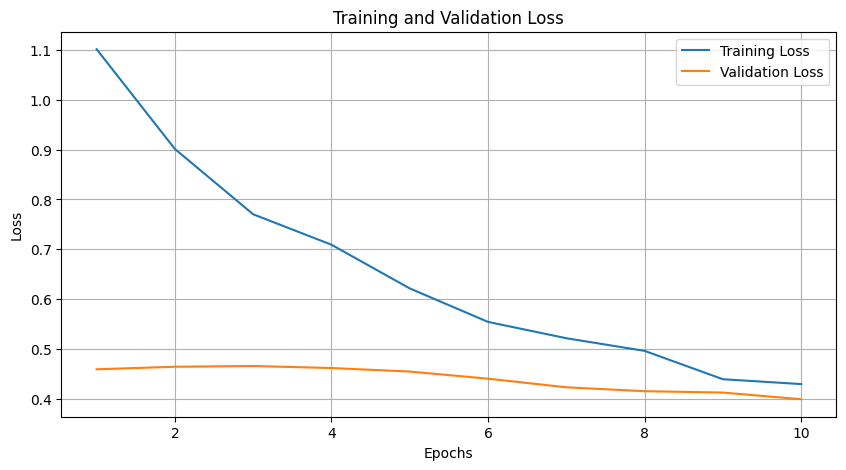

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step
                            precision    recall  f1-score   support

         Chromis_cyanea_ok       0.80      0.88      0.84       120
        Chromis_viridis_ok       0.76      0.86      0.81        99
Holacanthus_bermudensis_ok       0.94      0.91      0.93       132
           Odonus_niger_ok       0.94      0.78      0.85       129
  Paracanthurus_hepatus_ok       0.95      0.85      0.90       142
  Rhinomuraena_quaesita_ok       0.85      0.96      0.90        97
       Scarus_coeruleus_ok       0.75      0.80      0.78        91
 Thalassoma_bifasciatum_ok       0.88      0.86      0.87        91

                  accuracy                           0.86       901
                 macro avg       0.86      0.86      0.86       901
              weighted avg       0.87      0.86      0.86       901



In [ ]:
finetune_model = tf.keras.models.clone_model(best_model)
finetune_model.set_weights(best_model.get_weights())

for layer in finetune_model.layers[-20:]:
    layer.trainable = True

for layer in finetune_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

finetune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

history_fine_tuning = finetune_model.fit(train_generator,validation_data=val_generator,epochs=10)
plot_metrics(history_fine_tuning)

predictions = finetune_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


### MobileNet

To conclude, MobileNet performed very well for a lightweight model. The final model lacks precision on certain classes, specifically Chromis cyanea, Chromis viridis, and Scarus coeruleus event with the data augmentation.

To improve the model's precision, a focus should be placed on these classes. For example, we could add specific class weights to help the model or conduct an analysis of the problematic images.

In the end, we obtained a decent model.

# Vision transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from transformers import ViTConfig, ViTForImageClassification
import copy

# Vision Transformers require specific input resolution usually 224x224
image_size = 224
batch_size = 32

# 1. Resize image to 224x224.
# 2. Convert to Tensor (0-1).
# 3. Normalize to (-1, 1) range, which matches the pre-training of ViT models.

transform = T.Compose([T.Resize((image_size, image_size)),T.ToTensor(),T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_data = torchvision.datasets.ImageFolder(root=f"{data_dir}/validation", transform=transform)
test_data = torchvision.datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

num_classes = len(train_data.classes)
class_labels = train_data.classes

class CustomViT(nn.Module):
    def __init__(self, num_classes):


        # Load configuration from Hugging Face
        # Augmentation of the dropout probabilities to force strong regularization
        super().__init__()
        config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
        config.update({"hidden_dropout_prob": 0.3,"attention_probs_dropout_prob": 0.3})
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            config=config,
            ignore_mismatched_sizes=True
        )

        # MLP Head for better fine tuning
        hidden_dim = 512
        self.vit.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# TRAINING & EVALUATION FUNCTIONS
# ---------------------------------------------------------

def train_one_epoch(model, dataloader, optimizer, device, l1_lambda):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
        loss = loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return total_loss / total, correct / total

def evaluate(model, dataloader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return total_loss / total, correct / total

# ---------------------------------------------------------
# GRID SEARCH HYPERPARAMETER TUNING
# -------------------------------------------------------
learning_rates_to_test = [1e-4, 1e-5, 5e-6]
grid_search_epochs = 3
l1_lambda = 1e-5

best_overall_acc = 0.0
best_lr = None


for lr in learning_rates_to_test:

    model = CustomViT(num_classes=num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(grid_search_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, l1_lambda)
        val_loss, val_acc = evaluate(model, val_loader, device)

        print(f"  Epoch {epoch+1}/{grid_search_epochs} | LR: {lr} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_overall_acc:
            best_overall_acc = val_acc
            best_lr = lr

print(f"Best learning rate found: {best_lr} with a validation accuracy of {best_overall_acc:.4f}")

# ---------------------------------------------------------
# FINAL TRAINING RUN
# ---------------------------------------------------------

final_model = CustomViT(num_classes=num_classes).to(device)
optimizer = optim.AdamW(final_model.parameters(), lr=best_lr)

final_train_epochs = 15
best_final_acc = 0.0
best_model_final_path = "best_model_final.pth"

for epoch in range(final_train_epochs):
    train_loss, train_acc = train_one_epoch(final_model, train_loader, optimizer, device, l1_lambda)
    val_loss, val_acc = evaluate(final_model, val_loader, device)

    print(f"Epoch Final {epoch+1}/{final_train_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_final_acc:
        best_final_acc = val_acc
        torch.save(final_model.state_dict(), best_model_final_path)
final_model.load_state_dict(torch.load(best_model_final_path))

# ---------------------------------------------------------
# TESTING & REPORTING
# ---------------------------------------------------------

test_loss, test_accuracy = evaluate(final_model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

final_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = final_model(images)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | LR: 0.0001 | Train Loss: 53.5943, Acc: 0.5068 | Val Loss: 0.8017, Acc: 0.8004
  Epoch 2/3 | LR: 0.0001 | Train Loss: 49.2914, Acc: 0.8507 | Val Loss: 0.1763, Acc: 0.9583
  Epoch 3/3 | LR: 0.0001 | Train Loss: 47.1586, Acc: 0.9423 | Val Loss: 0.1694, Acc: 0.9518


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | LR: 1e-05 | Train Loss: 55.8253, Acc: 0.1807 | Val Loss: 2.0559, Acc: 0.2939
  Epoch 2/3 | LR: 1e-05 | Train Loss: 55.3858, Acc: 0.3287 | Val Loss: 2.0094, Acc: 0.6689
  Epoch 3/3 | LR: 1e-05 | Train Loss: 54.9318, Acc: 0.5113 | Val Loss: 1.9135, Acc: 0.8531


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/3 | LR: 5e-06 | Train Loss: 55.9381, Acc: 0.1382 | Val Loss: 2.0701, Acc: 0.1447
  Epoch 2/3 | LR: 5e-06 | Train Loss: 55.7187, Acc: 0.1645 | Val Loss: 2.0560, Acc: 0.2061
  Epoch 3/3 | LR: 5e-06 | Train Loss: 55.5073, Acc: 0.2063 | Val Loss: 2.0339, Acc: 0.3531
Best learning rate found: 0.0001 with a validation accuracy of 0.9583


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch Final 1/15 | Train Loss: 53.6021, Acc: 0.5179 | Val Loss: 0.7061, Acc: 0.8662
Epoch Final 2/15 | Train Loss: 49.4059, Acc: 0.8659 | Val Loss: 0.1789, Acc: 0.9583
Epoch Final 3/15 | Train Loss: 47.4542, Acc: 0.9487 | Val Loss: 0.1217, Acc: 0.9671
Epoch Final 4/15 | Train Loss: 46.0348, Acc: 0.9594 | Val Loss: 0.1844, Acc: 0.9474
Epoch Final 5/15 | Train Loss: 44.7816, Acc: 0.9740 | Val Loss: 0.1083, Acc: 0.9759
Epoch Final 6/15 | Train Loss: 43.6222, Acc: 0.9753 | Val Loss: 0.2423, Acc: 0.9583
Epoch Final 7/15 | Train Loss: 42.5595, Acc: 0.9753 | Val Loss: 0.1215, Acc: 0.9715
Epoch Final 8/15 | Train Loss: 41.5349, Acc: 0.9832 | Val Loss: 0.1556, Acc: 0.9627
Epoch Final 9/15 | Train Loss: 40.5342, Acc: 0.9870 | Val Loss: 0.1905, Acc: 0.9671
Epoch Final 10/15 | Train Loss: 39.5214, Acc: 0.9968 | Val Loss: 0.1733, Acc: 0.9649
Epoch Final 11/15 | Train Loss: 38.6774, Acc: 0.9740 | Val Loss: 0.2058, Acc: 0.9583
Epoch Final 12/15 | Train Loss: 37.7943, Acc: 0.9864 | Val Loss: 0.1600, A

### Vit vs MobileNetV2

I used two models one based on MobileNetV2 and the other on ViT. The ViT model consistently demonstrated significantly better performance than MobileNetV2.

The reason why the Vision Transformer outperformed MobileNetV2 is likely that the weights for google/vit-base-patch16-224-in21k were pre-trained on a substantially larger dataset (14 million images) than models typically trained only on the classic ImageNet (1.3 million images).

To gain a clearer understanding of the intrinsic performance of each architecture, I should train both models from scratch using random initialization Xavier for example rather than relying solely on pre trained weights.